In [1]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "talk", style="ticks", rc=custom_params) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression 
from pathlib import Path
import pandas as pd
from pathlib import Path
from scipy.signal import correlate, correlation_lags
import re


class MSDcalculator_saver:
    def __init__(self, pickle_path, save_dir="./Results/test/", new_timestep=0.01):
        self.new_timestep = new_timestep
        self.fs = round(1 / new_timestep)
        self._load_pickle(pickle_path)
        self._resample_data()
        self.compute_velocities()
        self.save_dir = Path(save_dir) / Path(pickle_path).stem
        self.T = self.extract_T(str(pickle_path))
        print(self.T)

    def _load_pickle(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.raw_data = data
        self.tau = data["tau"]
        self.num_trajectories = data["N_trajectories"]

        self.x_all = [np.array(data[f"x_{i}"]) for i in range(self.num_trajectories)]
        self.y_all = [np.array(data[f"y_{i}"]) for i in range(self.num_trajectories)]
        self.phi_all = [
            np.array(data.get(f"phi_{i}", np.zeros_like(self.x_all[i])))
            for i in range(self.num_trajectories)
        ]
        self.t = np.array(data["t"])

    def _resample_data(self): # Marc shenanigans, useful for long trajectories. Unsure I actually need it !
        idx_step = round(self.new_timestep / self.tau)
        self.fs = round(1 / self.new_timestep)
        self.t = self.t[::idx_step]

        self.x_all = [x[::idx_step] for x in self.x_all]
        self.y_all = [y[::idx_step] for y in self.y_all]
        self.phi_all = [phi[::idx_step] for phi in self.phi_all]


    @staticmethod
    def extract_T(name): # Utility function. Will be liberally copy pasted everywhere in this notebook.
        match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None
    
    def dedrift(self, x, y): # Juls shenanigans : I dont use wavelett directly but dedrift with linregress. It works really well on my simulations, but Marc lacks resolution with his experiments.
        T = 2 #quick fix self.T
        t = self.t
        y_smooth = gaussian_filter1d(y, sigma=5)

        omega = 2 * np.pi / T
        sin_t = np.sin(omega * t)
        cos_t = np.cos(omega * t)

        X = np.column_stack([
            sin_t,
            cos_t,
            y_smooth * sin_t,
            y_smooth * cos_t
        ])

        x_mean = np.mean(x)
        x_centered = x - x_mean

        model = LinearRegression().fit(X, x_centered)
        oscillatory_est = model.predict(X)
        x_dedrifted = x_centered - oscillatory_est + x_mean

        return t, x_dedrifted, None
    

    def compute_average_msd(self, signal_list):
        """
        Computes average MSD across multiple trajectories using fixed lag times.
        """
        lag_steps = np.hstack([np.arange(10 ** i, 10 ** (i + 1), 10 ** i) for i in range(8)])
        lag_times = lag_steps / self.fs 
    
        def MSD_fixed(x, lags):
            msd = np.zeros(len(lags))
            for n, lag in enumerate(lags):
                if lag >= len(x):
                    msd[n] = np.nan
                else:
                    msd[n] = np.nanmean((x[:-lag] - x[lag:])**2) # !!!!!!!!!!!! careful MSD definition
            return msd
    
        all_msd = []
        for signal in signal_list:
            msd_vals = MSD_fixed(signal, lag_steps)
            all_msd.append(msd_vals)
    
        all_msd = np.array(all_msd)
        msd_avg = np.nanmean(all_msd, axis=0)
        msd_std = np.nanstd(all_msd, axis=0)
        return lag_times, msd_avg, msd_std
    
    def compute_all_average_msds(self):
        """
        Compute and cache MSDs for x, y, phi, and dedrifted x.
        """
        self.msd_data = {} # Dict for storing.

        for comp in ['x', 'y', 'phi']:
            signal_list = getattr(self, f"{comp}_all")
            scales, avg, std = self.compute_average_msd(signal_list)
            self.msd_data[comp] = {'scales': scales, 'avg': avg, 'std': std}

        dedrifted_signals = [self.dedrift(self.x_all[i], self.y_all[i])[1] for i in range(len(self.x_all))]
        scales, avg, std = self.compute_average_msd(dedrifted_signals)
        self.msd_data['xhat'] = {'scales': scales, 'avg': avg, 'std': std}

    def save_msd_to_csv(self, save_path):
        if not hasattr(self, 'msd_data'):
            self.compute_all_average_msds()

        data = self.msd_data

        df = pd.DataFrame({
            "msdx": data['x']['avg'],
            "stdx": data['x']['std'],
            "msdy": data['y']['avg'],
            "stdy": data['y']['std'],
            "msdphi": data['phi']['avg'],
            "stdphi": data['phi']['std'],
            "msdxhat": data['xhat']['avg'],
            "stdxhat": data['xhat']['std'],
            "t": data['x']['scales']  
        })

        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        save_path_csv = str(save_path) + "/MSD.csv"
        df.to_csv(save_path_csv, index=False)
        print(f"MSD CSV saved to: {save_path_csv}")


    def compute_velocities(self):
        xhat_all = [self.dedrift(self.x_all[i], self.y_all[i])[1] for i in range(len(self.x_all))]
        self.vx_all = [(np.asarray(xhat)[1:] - np.asarray(xhat)[:-1]) / self.new_timestep
                       for xhat in xhat_all]
        self.vy_all = [(np.asarray(y)[1:] - np.asarray(y)[:-1]) / self.new_timestep
                       for y in self.y_all]
        


    def compute_correlations(self, signal_list, normalize=True, detrend=True, mode='full'):
        per_traj_corrs = []

        for s in signal_list:
            x = np.asarray(s, dtype=float)
            if detrend:
                x = x - np.nanmean(x)
            # Autocorrelation
            c = correlate(x, x, mode=mode)
            
            if normalize:
                var = np.nanvar(x)
                c = c / (var * len(x))
            per_traj_corrs.append(c)

        per_traj_corrs = np.vstack(per_traj_corrs) 
        avg_correlations = np.nanmean(per_traj_corrs, axis=0)
        std_correlations = np.nanstd(per_traj_corrs, axis=0)

        lags = correlation_lags(len(per_traj_corrs), len(per_traj_corrs), mode=mode)
        time_array = lags * self.new_timestep

        return time_array, avg_correlations, std_correlations

    

    def compute_all_correlations(self):
        """
        Computes averaged autocorrelations for vx and vy and caches them in self.corr_data.
        """
        self.corr_data = {}

        # vx
        t_x, avg_x, std_x = self.compute_correlations(self.vx_all, normalize=True, detrend=True)
        self.corr_data['x'] = {'scales': t_x, 'avg': avg_x, 'std': std_x}

        # vy
        t_y, avg_y, std_y = self.compute_correlations(self.vy_all, normalize=True, detrend=True)
        self.corr_data['y'] = {'scales': t_y, 'avg': avg_y, 'std': std_y}



    def save_corrs_to_csv(self, save_path):
        if not hasattr(self, 'corr_data'):
            self.compute_all_correlations()

        data = self.corr_data

        df = pd.DataFrame({
            "corrVx": data['x']['avg'],
            "stdcorrVx": data['x']['std'],
            "corrVy": data['y']['avg'],
            "stdcorrVy": data['y']['std'],
            "t": data['x']['scales']  
        })

        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        save_path_csv = str(save_path) + "/corrs.csv"
        df.to_csv(save_path_csv, index=False)
        print(f"correlations saved to: {save_path_csv}")
        

    



# Euhheuhghhg I hate it but I didn't feel like automating file naming back in February 2025 and now i dont wanna do it.

ok im gonna do it

In [3]:
CHANGE_THIS_NAME_TO_CASE_STUDY = "/answer_referee_1_hydrodynamics_with_brenner_multiT"

In [4]:
import os
os.makedirs("./Results", exist_ok=True)

os.makedirs("./Results" + CHANGE_THIS_NAME_TO_CASE_STUDY, exist_ok = True)


In [5]:
def path_function(base, extension, case_study) : # Culprit of my sorrows. Expects pickle in dir directly. Change it later maybe.
    data_directory = "./output_file/"
    picklefile = data_directory + case_study + base + extension

    result_directory = "./Results/"
    save_directory = result_directory + case_study
    save_path = save_directory + f"{base}"
    return save_path, picklefile


# Treatment of MSD data : fitting

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

class MSDtreatment:
    def __init__(self, save_dir="./Results/test/"):
        self.save_dir = save_dir 

    def _load_MSD_CSV(self, path):
        data = pd.read_csv(path)

        self.raw_data = data
        self.msdx = np.array(data["msdx"])
        self.stdx = np.array(data["stdx"])

        self.msdy = np.array(data["msdy"])
        self.stdy = np.array(data["stdy"])

        self.msdphi = np.array(data["msdphi"])
        self.stdphi = np.array(data["stdphi"])

        self.msdxhat = np.array(data["msdxhat"])
        self.stdxhat = np.array(data["stdxhat"])

        self.timelags = np.array(data["t"])
        
         

    def plot_all_average_msds_fit(self, csv_path=None, save_path=None, show=True, fit=True):
        if csv_path:
            self._load_MSD_CSV(csv_path)

        fig, axes = plt.subplots(2, 2, figsize=(13, 12))

        components = ['msdx', 'msdy', 'msdphi', 'msdxhat' ]
        titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
        colors = ["#46B9F7", '#FFAA33', '#99CC66', "#6C96FF"]
        fills = ['#7BDFFF', '#FFCC66', '#BBE29F', "#7D8AEB"]

        self.fit_results = {}

        for i, (comp, title, color, fill) in enumerate(zip(components, titles, colors, fills)):
            ax = axes.flat[i]
            msd = getattr(self, comp)
            std = getattr(self, f"std{comp[3:]}")
            t = self.timelags

            ax.loglog(t, msd, label="Simulation data", color=color, marker='o', markersize=5)
            ax.fill_between(t, msd - std, msd + std, color=fill, alpha=0.3, label="$\pm 1 \\times \sigma$")

            if fit and comp in ['msdxhat', 'msdy']:
                lower_short, upper_short = (1e-3, .1) if comp == 'msdxhat' else (1e-3, .01)
                slope_short, intercept_short, _, _, _ = self.fit_log_msd(t, msd, lower_short, upper_short)

                fit_line_short = 10**intercept_short * t[(t >= lower_short) & (t <= upper_short)]**slope_short
                ax.plot(t[(t >= lower_short) & (t <= upper_short)], fit_line_short, '--', color='green', label=fr"Short: $\sim$ {slope_short:.2f}")

                lower_long, upper_long = (5., 100.) if comp == 'msdxhat' else (90., 300.)
                slope_long, intercept_long, _, intercept_long_std, _ = self.fit_log_msd(t, msd, lower_long, upper_long)
                fit_line_long = 10**intercept_long * t[(t >= lower_long) & (t <= upper_long)]**slope_long
                ax.plot(t[(t >= lower_long) & (t <= upper_long)], fit_line_long, '--', color='black', label=fr"Long: $\sim$ {slope_long:.2f}")

                Deff = 10**intercept_long / 2
                stdDeff = (np.log(10) * 10**intercept_long / 2) * intercept_long_std

                self.fit_results[comp] = {
                    'slope_short': slope_short,
                    'intercept_short': intercept_short,
                    'slope_long': slope_long,
                    'intercept_long': intercept_long,
                    'Deff': Deff,
                    'stdDeff': stdDeff
                }
            else:
                self.fit_results[comp] = {
                    'slope_short': np.nan,
                    'intercept_short': np.nan,
                    'slope_long': np.nan,
                    'intercept_long': np.nan,
                    'Deff': np.nan,
                    'stdDeff': np.nan
                }

            ax.set_title(title)
            ax.set_xlabel(r"$\Delta t$ (s)")
            ax.set_ylabel("MSD ($m^2$)" if "phi" not in comp else "MSD ($rad^2$)")
            ax.grid(True, which="both", linestyle="--", alpha=0.3)
            ax.legend()

        if save_path:
            plt.savefig(save_path + "/MSD_fitted.pdf", transparent=True)
        if show:
            plt.show()
        plt.close()

    def save_fit_results(self, csv_path):
        with open(csv_path + "/fit_results.csv", 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Component', 'Short_Slope', 'Short_Intercept', 'Long_Slope', 'Long_Intercept', 'Deff', 'stdDeff'])

            for comp, result in self.fit_results.items():
                writer.writerow([
                    comp,
                    result.get('slope_short', np.nan),
                    result.get('intercept_short', np.nan),
                    result.get('slope_long', np.nan),
                    result.get('intercept_long', np.nan),
                    result.get('Deff', np.nan),
                    result.get('stdDeff', np.nan)
                ])

    def fit_log_msd(self, scales, msd, lower_bound_fit, upper_bound_fit):
        scales = np.array(scales)
        msd = np.array(msd)

        mask = (scales >= lower_bound_fit) & (scales <= upper_bound_fit)
        if np.sum(mask) < 2:
            print("Not enough points for fitting.")
            return np.nan, np.nan, np.nan, np.nan, np.nan

        x_fit = np.log10(scales[mask])
        y_fit = np.log10(msd[mask])
        (slope, intercept), cov = np.polyfit(x_fit, y_fit, 1, cov=True)
        slope_std = np.sqrt(cov[0, 0])
        intercept_std = np.sqrt(cov[1, 1])

        return slope, intercept, slope_std, intercept_std, cov


    def analyze_msd(self, csv_path, save_plot_path, save_txt_path):
        self.plot_all_average_msds_fit(csv_path=csv_path, save_path=save_plot_path, show=True, fit=True)
        self.save_fit_results(save_txt_path)
        




<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/1361463842.py:37: SyntaxWarning: invalid escape sequence '\p'
  titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/1361463842.py:37: SyntaxWarning: invalid escape sequence '\h'
  titles = ['$x$ component', '$y$ component', '$\phi$ (orientation)', '$\hat{x}$ (dedrifted)']
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/1361463842.py:50: SyntaxWarning: invalid escape sequence '\p'
  ax.fill_between(t, msd - std, msd + std, color=fill, alpha=0.3, label="$\pm 1 \\times \sigma$")


# Loop over all output files

In [7]:
import os
from pathlib import Path

# gRoot
case_study = CHANGE_THIS_NAME_TO_CASE_STUDY
output_folder = Path(f"./output_file/{case_study}") 

for pickle_path in output_folder.glob("*.pickle"): # Culprit too
    base_name = pickle_path.stem
    print(f"\nProcessing: {base_name}...")

    save_path = Path(f"./Results/{case_study}/{base_name}")
    save_path.mkdir(parents=True, exist_ok=True)

    csv_path = save_path / "MSD.csv"
    corr_path = save_path / "corrs.csv"
    fit_results_path = save_path / "fit_results.csv"
    msd_fit_plot_path = save_path / "MSD_fitted.pdf"
    msd_compare_plot_path = save_path / "MSD_comparison_xyphi_with_fit.pdf"
    

    if not csv_path.exists():
        analyzer = MSDcalculator_saver(pickle_path, save_dir=save_path)
        analyzer.save_msd_to_csv(save_path=save_path)
    else:
        print("[info] MSD CSV already exists. Skipping MSD CSV generation.")

    if not corr_path.exists():
        analyzer = MSDcalculator_saver(pickle_path, save_dir=save_path)
        analyzer.save_corrs_to_csv(save_path=save_path)
    else:
        print("[info] Correlations CSV already exists. Skipping correlation CSV generation.")


    if not fit_results_path.exists() or not msd_fit_plot_path.exists():
        fitter = MSDtreatment(save_dir=save_path)
        fitter.analyze_msd(csv_path=str(csv_path), save_plot_path=str(save_path), save_txt_path=str(save_path))
    else:
        print("[info] MSD fit results and plot already exists. Skipping...")




Processing: N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_3.72759372031494-L_0.088-W_0.00018-oscillations_True-task_0...
[info] MSD CSV already exists. Skipping MSD CSV generation.
2.0
correlations saved to: Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_3.72759372031494-L_0.088-W_0.00018-oscillations_True-task_0/corrs.csv
[info] MSD fit results and plot already exists. Skipping...

Processing: N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_26.826957952797247-L_0.088-W_0.00018-oscillations_True-task_0...
[info] MSD CSV already exists. Skipping MSD CSV generation.
2.0
correlations saved to: Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_

# Plot of msd xhat and corrs for various peclet

<>:58: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\m'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2309109259.py:58: SyntaxWarning: invalid escape sequence '\D'
  print(f"Plotting data for $\Delta$ P = {delta_p:.2e}")
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2309109259.py:64: SyntaxWarning: invalid escape sequence '\p'
  ax.fill_between(t, msd_drift - 1 * std, msd_drift + 1 * std, color=color, alpha=0.3, label="$\pm 1 \\times \sigma$")
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2309109259.py:72: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("MSD$[y]$ ($\mathrm{m}^2$)")


Found 10 MSD files.
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_0.0-L_0.088-W_0.00018-oscillations_True-task_0/MSD.csv
Plotting data for $\Delta$ P = 0.00e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_1.0-L_0.088-W_0.00018-oscillations_True-task_0/MSD.csv
Plotting data for $\Delta$ P = 1.00e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_1.93069772888325-L_0.088-W_0.00018-oscillations_True-task_0/MSD.csv
Plotting data for $\Delta$ P = 1.93e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_100.0-L_0.088-W_0.0001

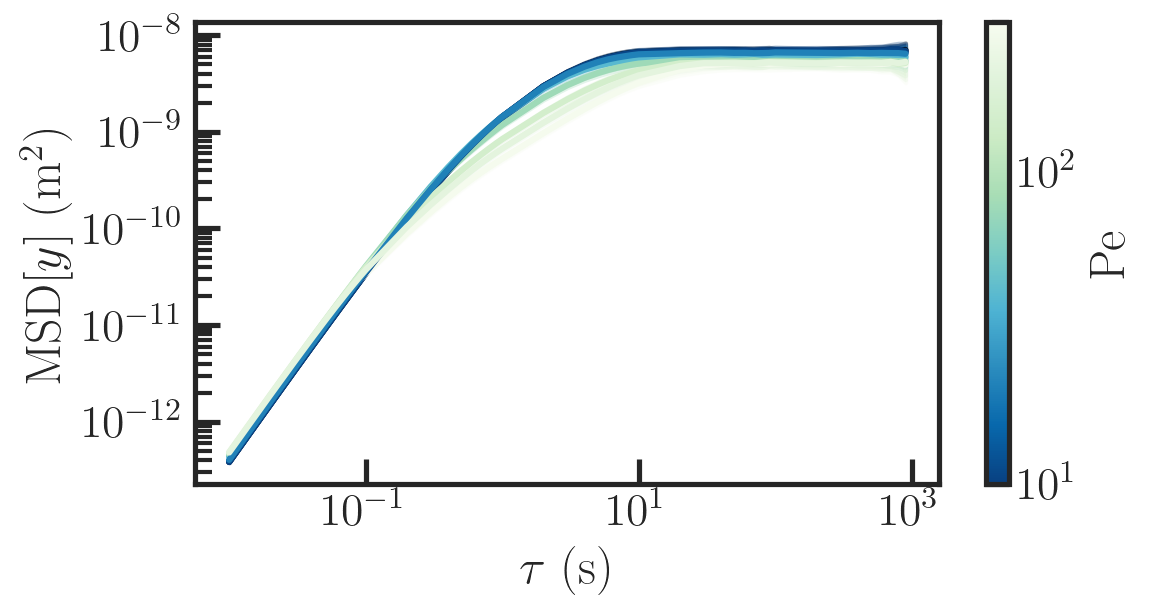

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

def extract_delta_p(name):
    match = re.search(r"delta_P_([0-9.eE+-]+)", name)
    if match:
        delta_p_str = match.group(1).rstrip('-')
        try:
            return float(delta_p_str)
        except ValueError:
            print(f"Could not convert '{delta_p_str}' to float.")
    return None

def extract_T(name):
    match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
    if match:
        T_str = match.group(1).rstrip('-')
        try:
            return float(T_str)
        except ValueError:
            print(f"Could not convert '{T_str}' to float.")
    return None

def Peclet_number_calculator(delta_p, D0): # Active oscillating 2D Peclet
    W = 180e-6
    L = 88e-3
    eta_0 = 1e-3
    u0 = 1 / (2 * eta_0) * delta_p / L * (W/2) ** 2 
    return (u0) * W / (D0) * 2/3 * 1/np.sqrt(2) 


fig, ax = plt.subplots(figsize=(6, 3))
results_root = Path("./Results/" + CHANGE_THIS_NAME_TO_CASE_STUDY)

csv_paths = sorted(results_root.glob("*/MSD.csv"))
print(f"Found {len(csv_paths)} MSD files.")


vmin, vmax = 10, 3e2 # messed up the min max thing. put it by hand for now. Update sept 2025 : Actually it's nice like this. keep it.
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
cmap = cm.GnBu_r

for csv_path in csv_paths:
    print(csv_path)
    df = pd.read_csv(csv_path)
    t = df["t"]
    msd_drift = df["msdy"] # Change this if youwanna look at another coordinate. It put y because the Peclet effect is fun.
    std = df["stdy"]

    delta_p = extract_delta_p(csv_path.parent.name)
    peclet = Peclet_number_calculator(delta_p, 1.3633762707901412e-09)
    T = extract_T(csv_path.parent.name)

    print(f"Plotting data for $\Delta$ P = {delta_p:.2e}")
    color = cmap(log_norm(peclet))
    label = r"$\mathcal{P}_e = {peclet:.0f}$"

    if T == 2: # Change this to monitor period effect.
        ax.loglog(t, msd_drift, label=label, color=color, alpha=1)
        ax.fill_between(t, msd_drift - 1 * std, msd_drift + 1 * std, color=color, alpha=0.3, label="$\pm 1 \\times \sigma$")


sm = cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"Pe")

ax.set_xlabel(r"$\tau$ (s)")
ax.set_ylabel("MSD$[y]$ ($\mathrm{m}^2$)")
# ax.grid(True, which="both", linestyle="--", alpha=0.5)


plt.savefig("y_MSD_comparison_deltaPlog.pdf", transparent=True, bbox_inches = 'tight')
# plt.tight_layout(w_pad = -.2)
plt.show()

<>:58: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\D'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/3425218464.py:58: SyntaxWarning: invalid escape sequence '\D'
  print(f"Plotting data for $\Delta$ P = {delta_p:.2e}")


Found 10 correlation files.
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_0.0-L_0.088-W_0.00018-oscillations_True-task_0/corrs.csv
Plotting data for $\Delta$ P = 0.00e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_1.0-L_0.088-W_0.00018-oscillations_True-task_0/corrs.csv
Plotting data for $\Delta$ P = 1.00e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_1.93069772888325-L_0.088-W_0.00018-oscillations_True-task_0/corrs.csv
Plotting data for $\Delta$ P = 1.93e+00
Results/answer_referee_1_hydrodynamics_with_brenner_multiT/N_1000000-tau_0.001-R_5e-06-H_0.0001-kbT_4.1399999999999995e-21-D_r_3.35-v_0.0001-T_2.0-tau_0.001-delta_P_100.0-L_

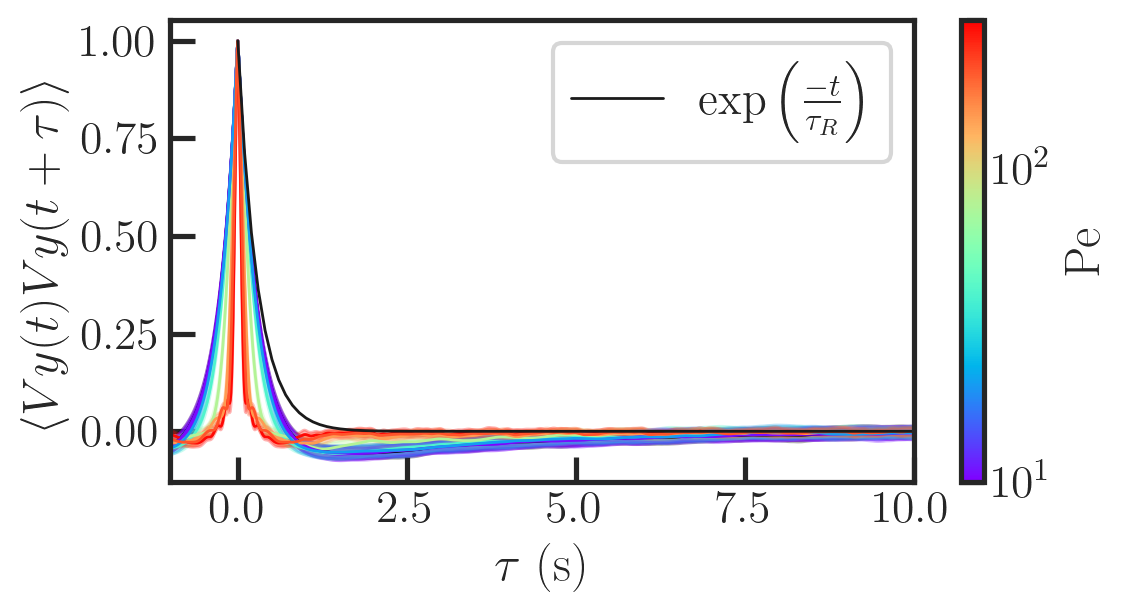

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

def extract_delta_p(name):
    match = re.search(r"delta_P_([0-9.eE+-]+)", name)
    if match:
        delta_p_str = match.group(1).rstrip('-')
        try:
            return float(delta_p_str)
        except ValueError:
            print(f"Could not convert '{delta_p_str}' to float.")
    return None

def extract_T(name):
    match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
    if match:
        T_str = match.group(1).rstrip('-')
        try:
            return float(T_str)
        except ValueError:
            print(f"Could not convert '{T_str}' to float.")
    return None

def Peclet_number_calculator(delta_p, D0): # Active oscillating 2D Peclet
    W = 180e-6
    L = 88e-3
    eta_0 = 1e-3
    u0 = 1 / (2 * eta_0) * delta_p / L * (W/2) ** 2 
    return (u0) * W / (D0) * 2/3 * 1/np.sqrt(2) 


fig, ax = plt.subplots(figsize=(6, 3))
results_root = Path("./Results/" + CHANGE_THIS_NAME_TO_CASE_STUDY)

csv_paths = sorted(results_root.glob("*/corrs.csv"))
print(f"Found {len(csv_paths)} correlation files.")


vmin, vmax = 10, 3e2 # messed up the min max thing. put it by hand for now. Update sept 2025 : Actually it's nice like this. keep it.
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
cmap = cm.rainbow

for csv_path in csv_paths:
    print(csv_path)
    df = pd.read_csv(csv_path)
    t = df["t"]
    corr = df["corrVy"] # Change this if youwanna look at another coordinate. It put y because the Peclet effect is fun.
    std = df["stdcorrVy"]

    delta_p = extract_delta_p(csv_path.parent.name)
    peclet = Peclet_number_calculator(delta_p, 1.3633762707901412e-09)
    T = extract_T(csv_path.parent.name)

    print(f"Plotting data for $\Delta$ P = {delta_p:.2e}")
    color = cmap(log_norm(peclet))
    if T == 2: # Change this to monitor period effect.
        ax.plot(t, corr, color=color, linewidth = 1., alpha=1)
        
        ax.fill_between(t, corr - 1 * std, corr + 1 * std, color=color, alpha=0.3, linewidth = 1.)

ax.plot(np.linspace(0, 10, 100), np.exp(-np.linspace(0, 10, 100) * 3.35), color = 'k', linewidth = 1., label = r"$\exp\left(\frac{-t}{\tau_R}\right)$")
sm = cm.ScalarMappable(cmap=cmap, norm=log_norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"Pe")

ax.set_xlim(-1, 10)
ax.set_xlabel(r"$\tau$ (s)")
ax.set_ylabel(r"$\langle Vy(t)Vy(t + \tau)\rangle$")
ax.legend()
# ax.grid(True, which="both", linestyle="--", alpha=0.5)


plt.savefig("autocorrelation_comparison_deltaPlog.pdf", transparent=True, bbox_inches = 'tight')
# plt.tight_layout(w_pad = -.2)
plt.show()

Found 10 MSD files.


<>:230: SyntaxWarning: invalid escape sequence '\m'
<>:235: SyntaxWarning: invalid escape sequence '\m'
<>:230: SyntaxWarning: invalid escape sequence '\m'
<>:235: SyntaxWarning: invalid escape sequence '\m'
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2978625012.py:230: SyntaxWarning: invalid escape sequence '\m'
  label=f"$\\alpha_\mathrm{{fit}}= {b_fit:.4f}$")
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2978625012.py:235: SyntaxWarning: invalid escape sequence '\m'
  plt.loglog(pe_line, 1 + 1/210 * pe_line , '--', color='k', label="$\\alpha_\mathrm{{theo}} = 1/210$", zorder = 5)
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2978625012.py:128: RuntimeWarning: divide by zero encountered in divide
  self.alpha_values = (self.intercept_Deff / self.D0_values_all - 1) / (self.peclet_values ** 2)


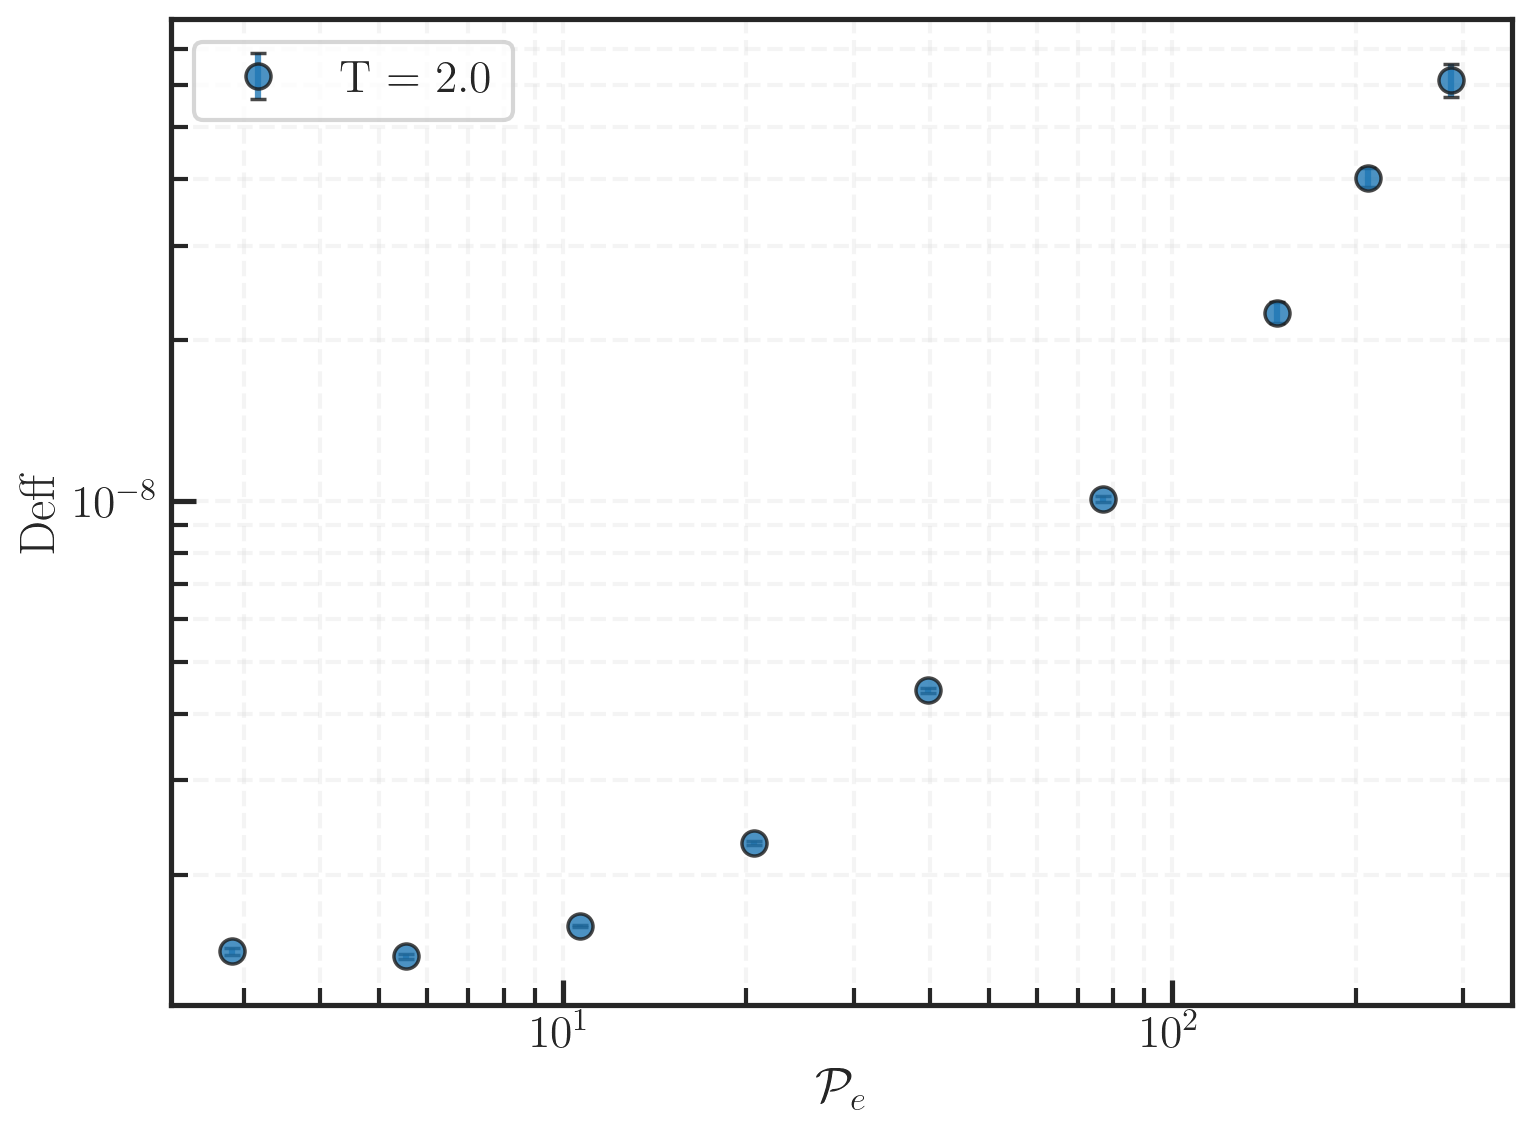

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/2978625012.py:165: RuntimeWarning: invalid value encountered in log10
  return np.log10(1 + b * pesq)


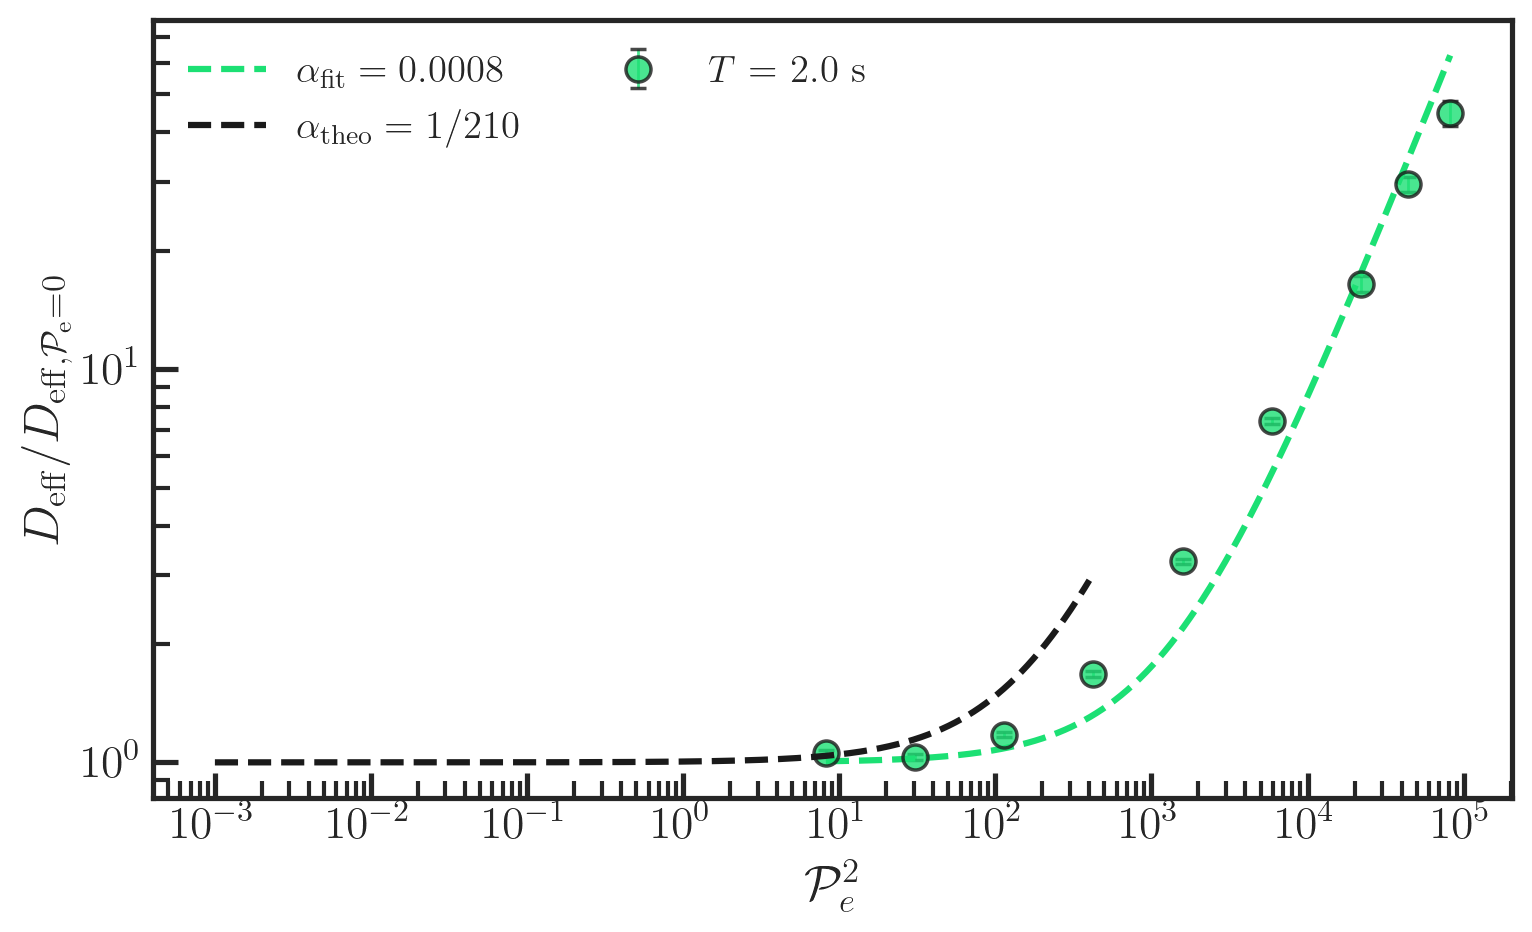

Alpha values: [0.0005352  0.00108217 0.00141678 0.00662788 0.00159548        inf
 0.00070412 0.00153329 0.00102664 0.0006519 ]
mean alpha: 0.0016859388115077504
std alpha: 0.0017852267948226853


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import re
import csv
from pathlib import Path
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap


class BradyFullAnalysis: # Perhaps change name as we are not Brady anymore.
    def __init__(self, results_root):
        self.results_root = Path(results_root)
        self.csv_paths = sorted(self.results_root.glob("*/MSD.csv"))
        self.T_values_all = [self.extract_T(p.parent.name) for p in self.csv_paths]
        self.deltap_values_all = [self.extract_delta_p(p.parent.name) for p in self.csv_paths]
        self.T_values_set = set(filter(None, self.T_values_all))
        self.T_to_color = {T: cm.tab10.colors[i % 10] for i, T in enumerate(self.T_values_set)}

        self.intercepts_x = []
        self.stdintercepts_x = []
        self.intercepts_y = []
        self.stdintercepts_y = []
        self.pressures = []
        self.T_list = []
        self.data_records = []

    @staticmethod
    def extract_T(name):
        match = re.search(r"(?<!kb)T_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None

    @staticmethod
    def extract_delta_p(name):
        match = re.search(r"delta_P_([0-9.eE+-]+)", name)
        return float(match.group(1).rstrip('-')) if match else None

    def D0_from_T_single(self, T): # \begin Painful
        return {
            1.0: 1.4509460868957787e-09,
            2.0: 1.3633762707901412e-09,
            4.0: 1.4202708043410992e-09,
            8.0: 1.6583595701294436e-09,
            16.0: 2.198442940667387e-09,
            32.0: 2.5690240231651334e-09,
            64.0 : 2.8429810872611832e-09,
            128.0 : 2.8521020173536553e-09,
        }.get(T, np.nan)
    
    def stdD0_from_T_single(self, T): 
        return {
            1.0: 1.7086393487229564e-11,
            2.0: 9.290666352880448e-12, 
            4.0: 3.344351199402897e-12, 
            8.0: 1.2332039601613544e-11, 
            16.0: 6.221357699145525e-11,
            32.0: 8.032121913692217e-11,
            64.0 : 9.700257949673962e-11,
            128.0 : 8.241080621528503e-11
        }.get(T, np.nan)

    def D0_from_T(self, T_list):
        return np.array([self.D0_from_T_single(T) for T in T_list])
    
    def stdD0_from_T(self, T_list):
        return np.array([self.stdD0_from_T_single(T) for T in T_list]) # \end Painful

    def Peclet_number_calculator(self, delta_ps, D0s): # Active oscillating 2D Peclet
        W = 180e-6
        L = 88e-3
        eta_0 = 1e-3
        u0 = 1 / (2 * eta_0) * delta_ps / L * (W/2) ** 2 
        return (u0) * W / (D0s) * 2/3 * 1/np.sqrt(2) 




    def extract_Deff_from_csv(self, csv_path, comp):
        results = []
        with open(csv_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['Component'] == comp and row['Deff'] and row['stdDeff']:
                    try:
                        Deff = float(row['Deff'])
                        stdDeff = float(row['stdDeff'])
                        results.append((Deff, stdDeff))
                    except ValueError:
                        continue
        return results


    def collect_Deff_data(self, comp):
        self.data_records.clear()

        for subdir in self.results_root.iterdir():
            if not subdir.is_dir():
                continue
            csv_path = subdir / "fit_results.csv"
            if not csv_path.exists():
                continue

            T = self.extract_T(subdir.name)
            delta_p = self.extract_delta_p(subdir.name)


            for Deff, stdDeff in self.extract_Deff_from_csv(csv_path, comp):
                if not np.isnan(Deff):
                    self.data_records.append({
                        "T": T,
                        "delta_p": delta_p,
                        "Deff": Deff,
                        "stdDeff": stdDeff,
                        "D0": self.D0_from_T_single(T),
                        "stdD0": self.stdD0_from_T_single(T),
                    })

        self.T_for_Deff = np.array([r["T"] for r in self.data_records])
        self.delta_p_values = np.array([r["delta_p"] for r in self.data_records])
        self.intercept_Deff = np.array([r["Deff"] for r in self.data_records])
        self.stdDeff = np.array([r["stdDeff"] for r in self.data_records])
        self.D0_values_all = np.array([r["D0"] for r in self.data_records])
        self.stdD0_values_all = np.array([r["stdD0"] for r in self.data_records])

        self.peclet_values = self.Peclet_number_calculator(self.delta_p_values, self.D0_values_all)
        self.alpha_values = (self.intercept_Deff / self.D0_values_all - 1) / (self.peclet_values ** 2)





    def plot_Deff(self):
        plt.figure(figsize=(8, 6))
        for T in sorted(set(self.T_for_Deff)):
            idx = self.T_for_Deff == T
            plt.errorbar(
                self.peclet_values[idx],
                self.intercept_Deff[idx],
                yerr=1.96 * self.stdDeff[idx],
                fmt='o',
                label=f"T = {T}",
                alpha=0.8,
                capsize=3,
                color=self.T_to_color.get(T, "gray")
            )
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel(r"$\mathcal{P}_e$")
        plt.ylabel("Deff")
        plt.grid(True, which="both", linestyle="--", alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.results_root / "D.pdf", transparent=True)
        plt.show()


    



    def plot_Deff_over_D0_by_T_fit(self):
        def model_log_deff(pesq, b):
            return np.log10(1 + b * pesq)

        plt.figure(figsize=(8, 5))
        results = []
        dfs_D = []

        one = "#1CE074"
        two = "#19CDCC"
        three = "#A040C6"
        cmap = LinearSegmentedColormap.from_list("custom_red_cyan", [one, two, three])

        unique_Ts = sorted(set(self.T_for_Deff))
        n_colors = len(unique_Ts)
        custom_colors = [cmap(i / (n_colors)) for i in range(n_colors)]

        for i, T in enumerate(unique_Ts):
            idx = self.T_for_Deff == T
            Pe2 = self.peclet_values[idx] ** 2

            Dx = self.intercept_Deff[idx]
            stdDx = self.stdDeff[idx]
            D0 = self.D0_values_all[idx]
            stdD0 = self.stdD0_values_all[idx] 

            Dx_D0 = Dx / D0
            stdDx_D0 = Dx_D0 * np.sqrt((stdDx / Dx) ** 2 + (stdD0 / D0) ** 2) * 1.96

            df = pd.DataFrame({
                f"Pe^2 (T={T})": Pe2,
                f"Dx/D0 (T={T})": Dx_D0,
                f"std Dx_D0 (T={T})": stdDx_D0,
                f"Dx (T={T})": Dx,
                f"stdDx (T={T})": stdDx,
            })
            dfs_D.append(df.reset_index(drop=True))

            mask = np.isfinite(Pe2) & np.isfinite(Dx_D0) & (Pe2 > 0) & (Dx_D0 > 0)
            if np.sum(mask) < 2:
                continue

            try:
                popt, pcov = curve_fit(model_log_deff, Pe2[mask], np.log10(Dx_D0[mask]))
                b_fit = popt[0]
                b_std = np.sqrt(pcov[0, 0])
            except Exception as e:
                print(f"Fit failed for T={T}: {e}")
                continue

            results.append({"T": T, "alpha": b_fit, "alpha_std": b_std})

            pesq_fit = np.logspace(np.log10(min(Pe2[mask])), np.log10(max(Pe2[mask])), 500)
            fit_vals = 10 ** model_log_deff(pesq_fit, b_fit)

            color = custom_colors[i]

            plt.errorbar(
                Pe2[mask], Dx_D0[mask],
                yerr=stdDx_D0[mask],
                fmt='o',
                color=color,
                capsize=3,
                elinewidth=1,
                label=f"$T$ = {T} s", alpha=0.8
            )
            plt.loglog(pesq_fit, fit_vals, '--', color=color,
                       label=f"$\\alpha_\mathrm{{fit}}= {b_fit:.4f}$")

        pd.concat(dfs_D, axis=1).to_csv(self.results_root / "DxD0_vs_Pe2.csv", index=False)

        pe_line = np.linspace(.001, 400, 50000)
        plt.loglog(pe_line, 1 + 1/210 * pe_line , '--', color='k', label="$\\alpha_\mathrm{{theo}} = 1/210$", zorder = 5)
        plt.xlabel(r"$\mathcal{P}_e^2$")
        plt.ylabel(r"$D_\mathrm{eff} / D_\mathrm{eff, \mathcal{P}_e = 0}$")
        plt.legend(fontsize=14, ncols=2, frameon=False)
        plt.tight_layout()
        plt.savefig(self.results_root / "DxD0_vs_Pe2_by_T.pdf", transparent=True)
        plt.show()
        pd.DataFrame(results).to_csv(self.results_root / "alpha_vs_T_fit_results.csv", index=False)





    def plot_Vratiosq_vs_Pesq_fit(self):
        def model_ratio_log(pe2, a, beta):
            return np.log10(a + beta * pe2)

        plt.figure(figsize=(8, 5))
        results = []
        dfs_v = []

        one = "#1CE074"
        two = "#19CDCC"
        three = "#A040C6"
        cmap = LinearSegmentedColormap.from_list("custom_red_cyan", [one, two, three])

        unique_Ts = sorted(set(self.T_list))
        n_colors = len(unique_Ts)
        custom_colors = [cmap(i / (n_colors)) for i in range(n_colors)]

        for i, T in enumerate(unique_Ts):
            idx = np.array(self.T_list) == T

            Pe2 = np.array(self.Peclet_number_calculator(
                np.array(self.pressures)[idx],
                self.D0_from_T(np.array(self.T_list)[idx])
            )) ** 2

            Vx2 = np.array(self.intercepts_x)[idx]
            Vy2 = np.array(self.intercepts_y)[idx]
            std_Vx2 = np.array(self.stdintercepts_x)[idx]
            std_Vy2 = np.array(self.stdintercepts_y)[idx]

            ratio = Vx2 / Vy2
            std_ratio = ratio * np.sqrt((std_Vx2 / Vx2) ** 2 + (std_Vy2 / Vy2) ** 2) * 1.96

            df = pd.DataFrame({
                f"Pe^2 (T={T})": Pe2,
                f"Vx^2/Vy^2 (T={T})": ratio,
                f"std Vx^2/Vy^2 (T={T})": std_ratio,
                f"Vx^2 (T={T})": Vx2,
                f"std Vx^2 (T={T})": std_Vx2,
                f"Vy^2 (T={T})": Vy2,
                f"std Vy^2 (T={T})": std_Vy2

            })
            dfs_v.append(df.reset_index(drop=True))

            mask = np.isfinite(Pe2) & np.isfinite(ratio) & (Pe2 > 0) & (ratio > 0)
            if np.sum(mask) < 2:
                continue
            try:
                log_ratio = np.log10(ratio[mask])
                popt, pcov = curve_fit(model_ratio_log, Pe2[mask], log_ratio, bounds=(0, np.inf))
                a_fit, beta_fit = popt
                a_std, beta_std = np.sqrt(np.diag(pcov))
            except Exception as e:
                print(f"Fit failed for T={T}: {e}")
                continue

            results.append({"T": T, "beta": beta_fit, "beta_std": beta_std})


            pesq_fit = np.logspace(np.log10(min(Pe2[mask])), np.log10(max(Pe2[mask])), 500)
            fit_vals = 10 ** model_ratio_log(pesq_fit, a_fit, beta_fit)


            color = custom_colors[i]
            plt.errorbar(
                Pe2[mask], ratio[mask],
                yerr=std_ratio[mask],
                fmt='o',
                color=color,
                capsize=3,
                elinewidth=1,
                label=f"$T$ = {T} s", alpha=0.8
            )
            plt.loglog(pesq_fit, fit_vals, '--', color=color,
                       label=f"$\\beta_\\mathrm{{fit}} = {beta_fit:.4f}$")
        pd.concat(dfs_v, axis=1).to_csv(self.results_root / "Vx2_Vy2_ratio_vs_Pe2_per_period.csv", index=False)
        plt.xlabel(r"$\mathcal{P}_e^2$")
        plt.ylabel(r"$\mathrm{MSV}_{\hat{x}}/\mathrm{MSV}_y$")
        plt.legend(fontsize=14, ncols=2, frameon=False)
        plt.ylim(1, None)
        plt.tight_layout()
        plt.savefig(self.results_root / "Vx2Vy2_vs_Pe2_by_T.pdf", transparent=True)
        plt.show()
        pd.DataFrame(results).to_csv(self.results_root / "beta_vs_T_fit_results.csv", index=False)






# ==== please work gods pleas e work please ====
results_root = "./Results/answer_referee_1_hydrodynamics_with_brenner_multiT"
brady = BradyFullAnalysis(results_root)

print(f"Found {len(brady.csv_paths)} MSD files.")

brady.collect_Deff_data("msdxhat")
brady.plot_Deff()
brady.plot_Deff_over_D0_by_T_fit()



# Peq de y

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_3259/999029454.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(cmap_name)


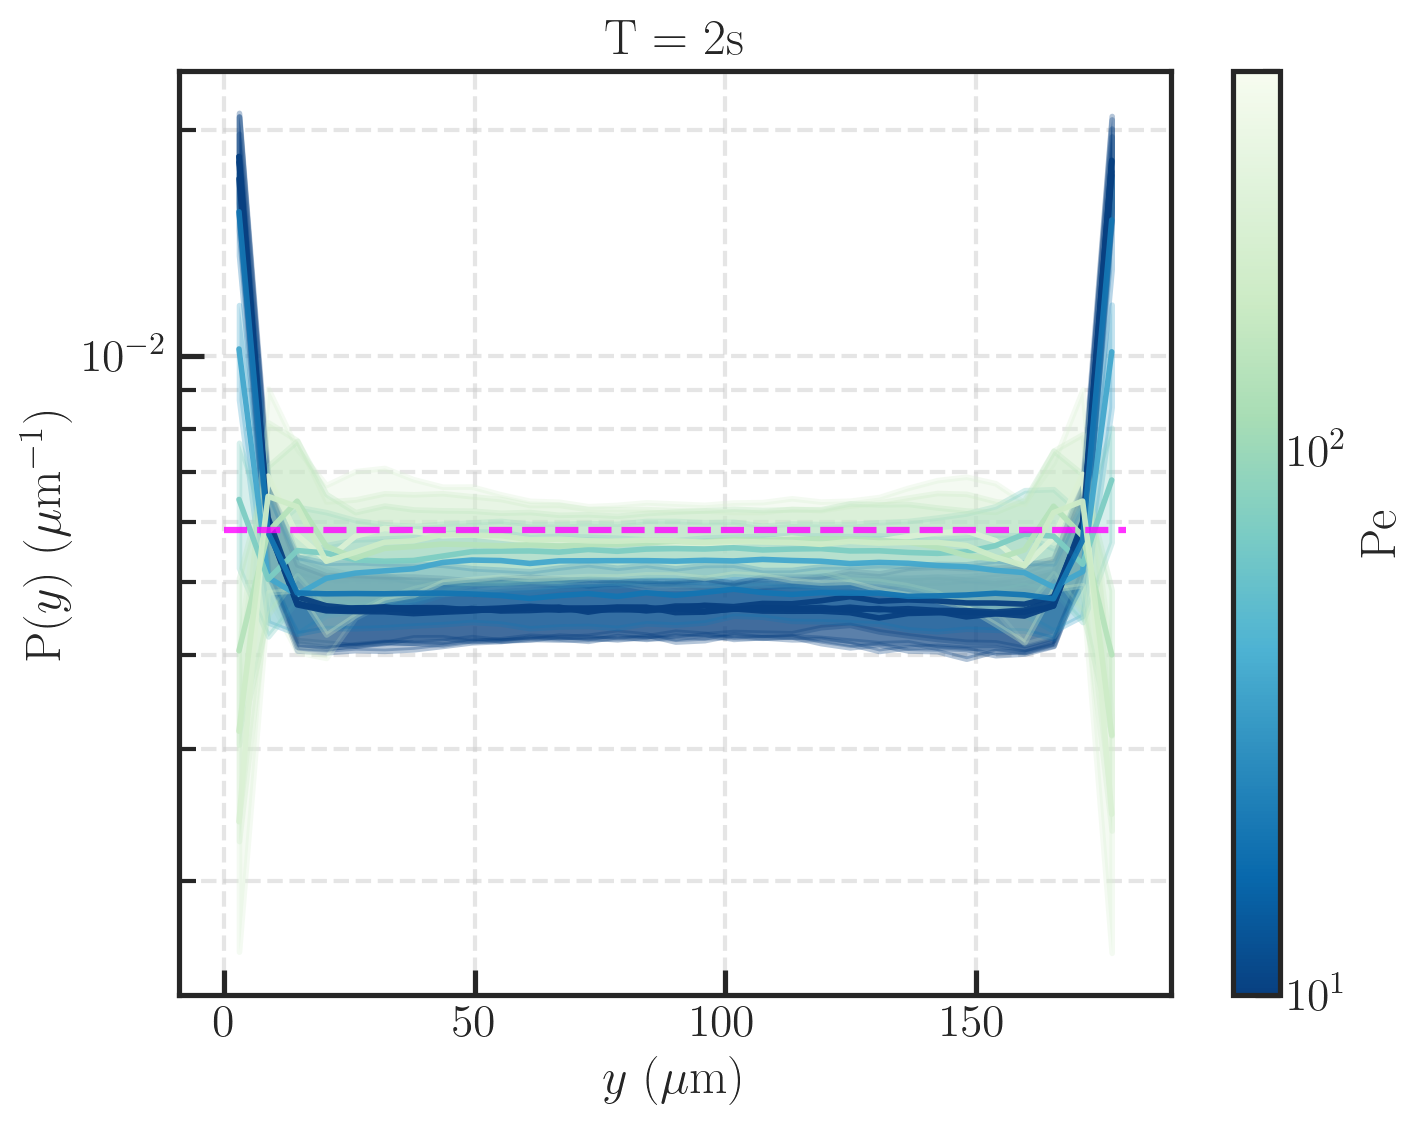

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import pandas as pd
from scipy.integrate import trapezoid
import json

class PDFcalculator_saver:
    def __init__(self, pickle_path=None, save_dir="./Results/test/", L=88e-3, H=170e-6, bins_per_dim=31, prefer_cached=True):
        self.L = L
        self.H = H
        self.bins_per_dim = bins_per_dim
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)

        # Fixed bin edges 
        self.bin_edges = {
            'x': np.linspace(-L, L, bins_per_dim + 1),
            'y': np.linspace(0,  H, bins_per_dim + 1),
            'phi': np.linspace(0, 2*np.pi, bins_per_dim + 1),
        }

        self.csv_path = self.save_dir / "PDF.csv"
        self.meta_path = self.save_dir / "PDF_meta.json"

        if prefer_cached and self.csv_path.exists():
            self._load_PDF_from_csv(self.csv_path)
            # If metadata present, update just in case
            if self.meta_path.exists():
                try:
                    meta = json.loads(self.meta_path.read_text())
                    self.L = float(meta.get("L", self.L))
                    self.H = float(meta.get("H", self.H))
                    self.bins_per_dim = int(meta.get("bins_per_dim", self.bins_per_dim))
                except Exception:
                    pass
        else:
            # Heavy : need pickle to compute
            self._load_pickle(pickle_path)
            self.compute_all_average_PDF()
            # save CSV + metadatsa for future fast loading
            self.save_PDF_to_csv(self.save_dir)
            self._save_meta()

    def _save_meta(self):
        meta = {
            "L": self.L,
            "H": self.H,
            "bins_per_dim": self.bins_per_dim,
        }
        self.meta_path.write_text(json.dumps(meta, indent=2))

    def _load_PDF_from_csv(self, csv_path: Path):
        df = pd.read_csv(csv_path)

        x_centers = df["x"].to_numpy()
        y_centers = df["y"].to_numpy()
        phi_centers = df["phi"].to_numpy()

        self.PDF_data = {
            "x":   {"scales": x_centers,   "avg": df["pdfx"].to_numpy(),   "std": df["stdx"].to_numpy()},
            "y":   {"scales": y_centers,   "avg": df["pdfy"].to_numpy(),   "std": df["stdy"].to_numpy()},
            "phi": {"scales": phi_centers, "avg": df["pdfphi"].to_numpy(), "std": df["stdphi"].to_numpy()},
        }

    def save_PDF_to_csv(self, save_path):
        """
        Save averages/stds PLUS bin centers so we can reload without recomputation.
        """
        if not hasattr(self, 'PDF_data'):
            self.compute_all_average_PDF()

        data = self.PDF_data
        df = pd.DataFrame({
            "x":      data['x']['scales'],
            "y":      data['y']['scales'],
            "phi":    data['phi']['scales'],
            "pdfx":   data['x']['avg'],
            "stdx":   data['x']['std'],
            "pdfy":   data['y']['avg'],
            "stdy":   data['y']['std'],
            "pdfphi": data['phi']['avg'],
            "stdphi": data['phi']['std'],
        })

        save_path = Path(save_path)
        save_path.mkdir(parents=True, exist_ok=True)
        (save_path / "PDF.csv").parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(save_path / "PDF.csv", index=False)
        print(f"PDF CSV saved to: {save_path}")


    def _load_pickle(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.raw_data = data
        self.tau = data["tau"]
        self.num_trajectories = data["N_trajectories"]

        self.x_all = [np.array(data[f"x_{i}"]) for i in range(self.num_trajectories)]
        self.y_all = [np.array(data[f"y_{i}"]) for i in range(self.num_trajectories)]
        self.phi_all = [
            np.array(data.get(f"phi_{i}", np.zeros_like(self.x_all[i])) % (2 * np.pi))
            for i in range(self.num_trajectories)
        ]
        self.t = np.array(data["t"])

    def compute_average_PDF(self, signal_list, comp_name):
        all_pdf = []
        for signal in signal_list:
            PDF_vals, bin_centers = self.compute_PDF(signal, bins=self.bin_edges[comp_name])
            all_pdf.append(PDF_vals)

        all_pdf = np.array(all_pdf)
        pdf_avg = np.nanmean(all_pdf, axis=0)
        pdf_std = np.nanstd(all_pdf, axis=0)
        return pdf_avg, pdf_std, bin_centers

    def compute_PDF(self, comp, bins=None, density=True):
        if bins is None:
            bins = 31
        pdf_comp, bins_edge_comp = np.histogram(comp, bins=bins, density=density)
        bins_center_comp = (bins_edge_comp[:-1] + bins_edge_comp[1:]) / 2
        return pdf_comp, bins_center_comp

    def compute_all_average_PDF(self):
        self.PDF_data = {}
        for comp in ['x', 'y', 'phi']:
            signal_list = getattr(self, f"{comp}_all")
            avg, std, scales = self.compute_average_PDF(signal_list, comp)
            self.PDF_data[comp] = {'scales': scales, 'avg': avg, 'std': std}


    def save_PDF_to_csv(self, save_path):
        """
        Save averages/stds PLUS bin centers to reload without recomputation.
        """
        if not hasattr(self, 'PDF_data'):
            self.compute_all_average_PDF()

        data = self.PDF_data
        df = pd.DataFrame({
            # bin centers
            "x":      data['x']['scales'],
            "y":      data['y']['scales'],
            "phi":    data['phi']['scales'],
            # values
            "pdfx":   data['x']['avg'],
            "stdx":   data['x']['std'],
            "pdfy":   data['y']['avg'],
            "stdy":   data['y']['std'],
            "pdfphi": data['phi']['avg'],
            "stdphi": data['phi']['std'],
        })

        save_path = Path(save_path)
        save_path.mkdir(parents=True, exist_ok=True)
        (save_path / "PDF.csv").parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(save_path / "PDF.csv", index=False)
        print(f"PDF CSV saved to: {save_path}")




class PDFDataFromCSV:
    def __init__(self, csv_dir: Path):
        df = pd.read_csv(csv_dir / "PDF.csv")
        self.PDF_data = {
            "x":   {"scales": df["x"].to_numpy(),   "avg": df["pdfx"].to_numpy(),   "std": df["stdx"].to_numpy()},
            "y":   {"scales": df["y"].to_numpy(),   "avg": df["pdfy"].to_numpy(),   "std": df["stdy"].to_numpy()},
            "phi": {"scales": df["phi"].to_numpy(), "avg": df["pdfphi"].to_numpy(), "std": df["stdphi"].to_numpy()},
        }



import os
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re



def get_or_build_analyzer(pickle_path: Path, save_root: Path, L=88e-3, H=180e-6, bins_per_dim=31):
    base_name = pickle_path.stem
    save_dir = save_root / base_name
    analyzer = PDFcalculator_saver(
        pickle_path=pickle_path,
        save_dir=save_dir,
        L=L, H=H, bins_per_dim=bins_per_dim,
        prefer_cached=True,  
    )
    return base_name, analyzer

def eq4paper(y, A, B, lambd) :
    return A + B/2 * np.cosh(lambd * (y -90*1e-6))



def plot_combined_y_PDFs(results, save_path=None, show=True, cmap_name="GnBu_r", vmin=10.0, vmax=5e2):
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = mcolors.LogNorm(vmin=float(vmin), vmax=float(vmax))
    colormap = cm.get_cmap(cmap_name)

    def extract_delta_p(name: str):
        m = re.search(r"delta_P_([0-9.eE+\-]+)", name)
        if not m:
            return None
        try:
            return float(m.group(1).rstrip('-'))
        except Exception:
            return None
        
        
    def Peclet_number_calculator(delta_p, D0):
        W = 180e-6
        L = 88e-3
        eta_0 = 1e-3
        u0 = 1 / (2 * eta_0) * delta_p / L * (W/2) ** 2 
        return (u0) * W / (D0) * 2/3 * 1/np.sqrt(2) 

    for case_name, analyzer in sorted(results.items()):
        if not hasattr(analyzer, "PDF_data"): 
            analyzer.compute_all_average_PDF()

        dp = extract_delta_p(case_name) #peclet color coding
        Peclet = Peclet_number_calculator(dp, 1.44e-9)
        y_data = analyzer.PDF_data["y"]
    
        Peclet = max(min(Peclet, vmax), vmin)
        color = colormap(norm(Peclet))

        ax.semilogy(y_data["scales"]*1e6, y_data["avg"]*1e-6, lw=2, color=color, alpha=0.95, label=case_name)
        ax.fill_between(y_data["scales"]*1e6, y_data["avg"]*1e-6 - y_data["std"]*1e-6, y_data["avg"]*1e-6 + y_data["std"]*1e-6, lw=2, color=color, alpha=0.3, label=case_name)

    ax.hlines(5858*1e-6, 0, 180,  linestyle = '--', color = 'magenta', alpha = .8)

    ax.set_xlabel(r"$y$ ($\mu$m)")
    ax.set_ylabel(r"P($y$) ($\mu\mathrm{m}^{-1}$)")
    ax.set_title('T = 2s')
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(r"Pe")


    if save_path:
        save_path = Path(save_path)
        save_path.mkdir(parents=True, exist_ok=True)
        out_pdf = save_path / "Combined_y_PDFs.pdf"
        plt.savefig(out_pdf, transparent=True, bbox_inches="tight")

    if show:
        plt.show()

    plt.close()





case_study = "answer_referee_1_hydrodynamics_with_brenner_multiT"
output_folder = Path(f"./output_file/{case_study}")
results_root = Path(f"./Results/{case_study}")

results = {}

for pickle_path in output_folder.glob("*.pickle"):
    base_name, analyzer = get_or_build_analyzer(
        pickle_path=pickle_path,
        save_root=results_root,
        L=88e-3, H=180e-6, bins_per_dim=31
    )
    results[base_name] = analyzer

plot_combined_y_PDFs(results, save_path=f"./Results/{case_study}")


In [11]:
np.sqrt(1e5)

np.float64(316.22776601683796)

## Vxˆ2, Vyˆ2 = f(Peˆ2)